# BUS/FIN 241: Final Project
By: Kaichen Bian, Wendy Chen, David Liu, Longtao

### Our project aims to develop an efficient classification model for comment analysis in live stream chats, with a primary focus on maximizing recall. This approach emphasizes identifying as many relevant comments as possible, even at the cost of an increased number of false positives. Our priority is to detect abusive language in comments rather than risk failing to identify it.

In [10]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, make_scorer
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
# Load the data
train_df = pd.read_csv("/Users/madsbian/Desktop/train.csv")
test_df = pd.read_csv("/Users/madsbian/Desktop/test.csv")

# Data Exploration (Check for any missing values, general stats)
print("Training Data Info:")
print(train_df.info())
print("Testing Data Info:")
print(test_df.info())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119678 entries, 0 to 119677
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            119678 non-null  object
 1   comment_text  119678 non-null  object
 2   target        119678 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 1.9+ MB
None
Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39893 entries, 0 to 39892
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            39893 non-null  object
 1   comment_text  39893 non-null  object
dtypes: object(2)
memory usage: 623.5+ KB
None


Data Cleaning and Preprocessing

In [3]:
# Data Cleaning and Preprocessing Function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'\W|\d', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to the training and testing data
train_df['comment_text'] = train_df['comment_text'].apply(preprocess_text)
test_df['comment_text'] = test_df['comment_text'].apply(preprocess_text)

In [4]:
test_df.head()

,id,comment_text
0,92ffa14d7a3e2366,germany took over most of it and
1,d92d8563b3b0d425,just expanded the article and added infobox di...
2,63c98cbb7926a40e,skater chick skater chick
3,c8faa29895ea5fae,i am the creator of the ctrl alt del webcomic
4,0a2aa77d05017c03,butter is butter substitute the references giv...


In [5]:
train_df.head()

,id,comment_text,target
0,ca8a57ab7711d617,how is it known that they originate from israe...,False
1,23fc15ce884f552a,this article is nominated for the below mentio...,False
2,9e6faa999c8f031d,and dispute resolution how many times have tri...,True
3,4810b6c16dec5186,perhaps perhaps you didn read the article whic...,False
4,71524666e604273a,pushing it unclear what you think is pushing i...,False


In [6]:
#Split the Data into Training and Validation Sets
nltk.download('stopwords')
X = train_df['comment_text']
y = train_df['target'].astype(int)
X_test = test_df['comment_text']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madsbian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    ngram_range=(1, 2)
)
X_train_tfidf_full = tfidf_vectorizer.fit_transform(X_train)

### Stochastic Gradient Descent 

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Term Frequency Inverse Document Frequency method: converts data into numerical vectors

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords.words('english'),
        ngram_range=(1, 2) #unigram and bigrams
    )),
    ('clf', SGDClassifier(
        loss='log_loss',  #logisitic regression
        tol=1e-3, #Tolerance: treshold for a convergence 
        early_stopping=True, #Stops training if validation performance doesn't improve
        validation_fraction=0.1, #10% of training data for validation
        n_iter_no_change=5, #Number of consectuive iterations where model's performance does not improve significantly
        random_state=42
    ))
])

# Define parameter grid
param_grid = {
    'tfidf__max_features': [1000, 2500, 3000], #Maximum number of features (words or bigrams) in TF-IDF matrix
    'clf__max_iter': [1000,5000,10000], #Maximum number of iterations for SGD optimiztion
    'clf__alpha': [1e-4, 1e-3, 1e-2] #Regularization strength
}

In [9]:
grid_search = GridSearchCV(
    estimator=pipeline, #The pipeline to optimize (defined earlier)
    param_grid=param_grid, #Dictionary of hyperparameters to tune
    scoring='f1', #Metric to evaluate the model's performance
    cv=5, #Number of folds for cross-validation
    n_jobs=-1 #Use all available CPU cores for parallel processing
)


# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      loss='log_loss',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__max_iter': [1000, 5000, 10000],
                         'tfidf__max_features': [1000, 2500, 3000]},
             scoring='f1')

In [11]:
# Get the best estimator and parameters
best_pipeline = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

#Evaluate on validation data
y_val_pred = best_pipeline.predict(X_val)
f1 = f1_score(y_val, y_val_pred)
print(f"Validation F1 Score with Best Parameters: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Best parameters: {'clf__alpha': 0.0001, 'clf__max_iter': 1000, 'tfidf__max_features': 2500}
Validation F1 Score with Best Parameters: 0.5511
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     21502
           1       0.98      0.38      0.55      2434

    accuracy                           0.94     23936
   macro avg       0.96      0.69      0.76     23936
weighted avg       0.94      0.94      0.92     23936

Confusion Matrix:
[[21483    19]
 [ 1501   933]]


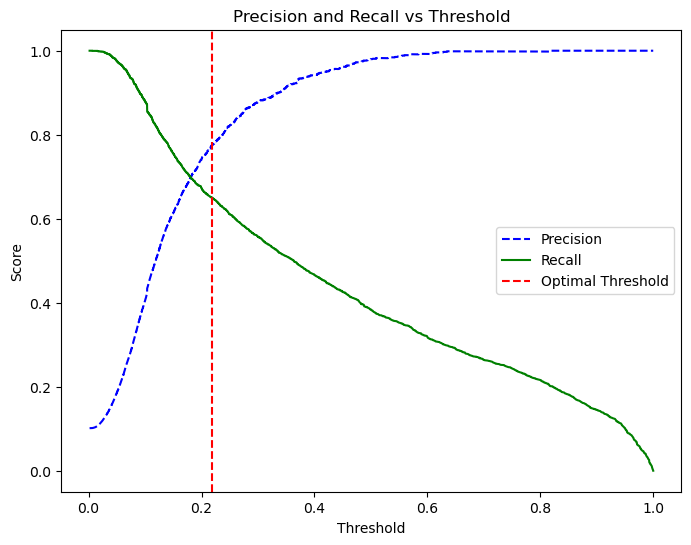

In [18]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,recall_score
import numpy as np

# Assuming you have the following predictions and true labels
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class (1)

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# Option 1: Calculate the optimal threshold based on F1 score
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])  # Calculate F1 for each point
optimal_index = np.argmax(f1_scores)  # Find the index of the maximum F1 score
optimal_threshold = thresholds[optimal_index]  # Get the corresponding threshold

# Plot precision and recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision and Recall vs Threshold')
plt.show()

In [19]:
y_val_probs = best_pipeline.predict_proba(X_val)[:, 1] 
threshold = 0.18  # Choose recall as the most important metric

# Make predictions on validation set
y_val_custom_pred = (y_val_probs >= threshold).astype(int)

# Evaluate performance on validation set
f1_custom = f1_score(y_val, y_val_custom_pred)
precision_custom = precision_score(y_val, y_val_custom_pred)
recall_custom = recall_score(y_val, y_val_custom_pred)

print(f"F1 Score with Threshold {threshold}: {f1_custom:.4f}")
print(f"Precision with Threshold {threshold}: {precision_custom:.4f}")
print(f"Recall with Threshold {threshold}: {recall_custom:.4f}")
print("Classification Report with Custom Threshold:")
print(classification_report(y_val, y_val_custom_pred))
print("Confusion Matrix with Custom Threshold:")
print(confusion_matrix(y_val, y_val_custom_pred))

F1 Score with Threshold 0.18: 0.6984
Precision with Threshold 0.18: 0.6966
Recall with Threshold 0.18: 0.7001
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21502
           1       0.70      0.70      0.70      2434

    accuracy                           0.94     23936
   macro avg       0.83      0.83      0.83     23936
weighted avg       0.94      0.94      0.94     23936

Confusion Matrix with Custom Threshold:
[[20760   742]
 [  730  1704]]


In [20]:
# Generate decision scores for the test set
# Ensure y_test_probs contains the probabilities for the positive class (class `1`)
y_test_probs = best_pipeline.predict_proba(X_test)[:, 1]

# Define the threshold (make sure this is set to your chosen optimal threshold)
threshold = 0.18  # Adjust this based on your previous analysis

# Make predictions on the test set using the custom threshold
y_test_pred = (y_test_probs >= threshold).astype(int)

# Include comment_text and id in the results DataFrame
results_df = pd.DataFrame({
    'id': test_df['id'],
    'comment_text': test_df['comment_text'],
    'target': y_test_pred
})

# Prepare the submission DataFrame with only id, comment_text, and target columns
submission_df = results_df[['id', 'comment_text', 'target']]

# Save the submission DataFrame to CSV
output_path = '/Users/madsbian/Desktop/submission_SGD.csv'
submission_df.to_csv(output_path, index=False)

print(f"Submission file saved to {output_path}")

Submission file saved to /Users/madsbian/Desktop/submission_SGD.csv


In [21]:
submission_df.head()

,id,comment_text,target
0,92ffa14d7a3e2366,germany took over most of it and,0
1,d92d8563b3b0d425,just expanded the article and added infobox di...,0
2,63c98cbb7926a40e,skater chick skater chick,0
3,c8faa29895ea5fae,i am the creator of the ctrl alt del webcomic,0
4,0a2aa77d05017c03,butter is butter substitute the references giv...,0


### Logisitic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)

# Define pipeline with Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords.words('english'),
        ngram_range=(1, 2)
    )),
    ('clf', LogisticRegression(
        solver='liblinear', 
        max_iter=1000,
        random_state=42
    ))
])

# Define parameter grid
param_grid = {
    'tfidf__max_features': [80000,85000,90000],
    'clf__C': [0.1, 1, 10, 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_pipeline = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on validation data
y_val_pred = best_pipeline.predict(X_val)
f1 = f1_score(y_val, y_val_pred)
print(f"Validation F1 Score with Best Parameters: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Best parameters: {'clf__C': 10, 'tfidf__max_features': 80000}
Validation F1 Score with Best Parameters: 0.7612
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     21502
           1       0.88      0.67      0.76      2434

    accuracy                           0.96     23936
   macro avg       0.92      0.83      0.87     23936
weighted avg       0.96      0.96      0.95     23936

Confusion Matrix:
[[21288   214]
 [  807  1627]]


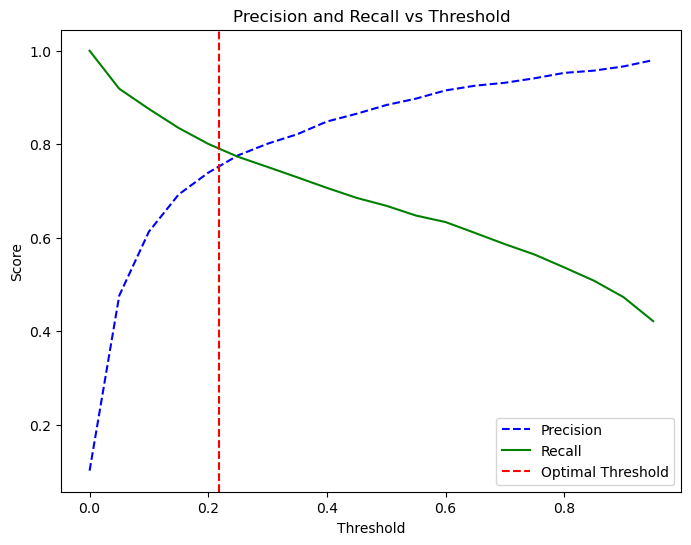

In [23]:
y_val_probs = best_pipeline.predict_proba(X_val)[:, 1]  # Get probabilities for class `1`
thresholds = np.arange(0.0, 1.0, 0.05)
precisions, recalls = [], []
for threshold in thresholds:
    y_val_custom_pred = (y_val_probs >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_val_custom_pred))
    recalls.append(recall_score(y_val, y_val_custom_pred))
# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, 'b--', label='Precision')
plt.plot(thresholds, recalls, 'g-', label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision and Recall vs Threshold')
plt.show()

In [24]:
optimal_threshold = 0.17  # Adjust as needed based on analysis
y_val_custom_pred = (y_val_probs >= optimal_threshold).astype(int)
print(f"F1 Score with Threshold {optimal_threshold}: {f1_score(y_val, y_val_custom_pred):.4f}")
print(f"Precision with Threshold {optimal_threshold}: {precision_custom:.4f}")
print(f"Recall with Threshold {optimal_threshold}: {recall_custom:.4f}")
print("Classification Report with Custom Threshold:")
print(classification_report(y_val, y_val_custom_pred))
print("Confusion Matrix with Custom Threshold:")
print(confusion_matrix(y_val, y_val_custom_pred))

F1 Score with Threshold 0.17: 0.7624
Precision with Threshold 0.17: 0.6966
Recall with Threshold 0.17: 0.7001
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     21502
           1       0.71      0.82      0.76      2434

    accuracy                           0.95     23936
   macro avg       0.84      0.89      0.87     23936
weighted avg       0.95      0.95      0.95     23936

Confusion Matrix with Custom Threshold:
[[20686   816]
 [  432  2002]]


In [25]:
# Generate decision scores and predictions for the test set
y_test_probs = best_pipeline.predict_proba(test_df['comment_text'])[:, 1]
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

# Prepare the submission DataFrame
results_df = pd.DataFrame({
    'id': test_df['id'],
    'comment_text': test_df['comment_text'],
    'target': y_test_pred
})
submission_df = results_df[['id', 'comment_text', 'target']]
output_path = '/Users/madsbian/Desktop/submission_Logistic.csv'
submission_df.to_csv(output_path, index=False)
print(f"Submission file saved to {output_path}")
submission_df.head()

Submission file saved to /Users/madsbian/Desktop/submission_Logistic.csv


,id,comment_text,target
0,92ffa14d7a3e2366,germany took over most of it and,0
1,d92d8563b3b0d425,just expanded the article and added infobox di...,0
2,63c98cbb7926a40e,skater chick skater chick,0
3,c8faa29895ea5fae,i am the creator of the ctrl alt del webcomic,0
4,0a2aa77d05017c03,butter is butter substitute the references giv...,0


### Bayesian Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)

# Define pipeline with Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stopwords.words('english'),
        ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB())
])

# Define parameter grid for MultinomialNB
param_grid = {
    'tfidf__max_features': [25000,30000,35000],
    'clf__alpha': [0.1,0.2,0.3]  # Smoothing parameter for Naive Bayes
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_pipeline = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'clf__alpha': 0.1, 'tfidf__max_features': 30000}


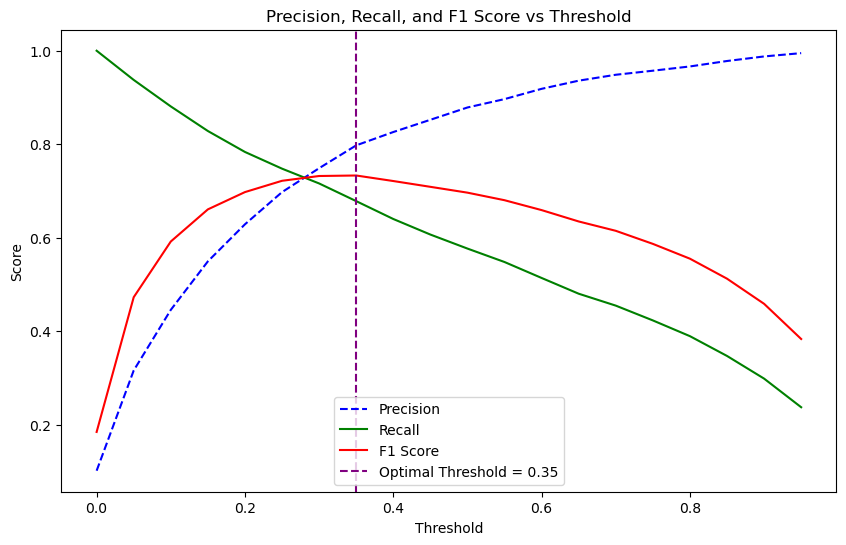

Optimal Threshold: 0.35000000000000003


In [413]:
# Evaluate on validation data
y_val_probs = best_pipeline.predict_proba(X_val)[:, 1]  # Get probabilities for class `1`
thresholds = np.arange(0.0, 1.0, 0.05)
precisions, recalls, f1_scores = [], [], []
for threshold in thresholds:
    y_val_custom_pred = (y_val_probs >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_val_custom_pred))
    recalls.append(recall_score(y_val, y_val_custom_pred))
    f1_scores.append(f1_score(y_val, y_val_custom_pred))
    # Plot Precision, Recall, and F1 Score vs Threshold
# Plot Precision, Recall, and F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, 'b--', label='Precision')
plt.plot(thresholds, recalls, 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')

# Mark the optimal threshold with a vertical line
plt.axvline(x=optimal_threshold, color='purple', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.show()
print(f"Optimal Threshold: {optimal_threshold}")

In [422]:
# Make predictions on validation set with optimal threshold
optimal_threshold = 0.3
y_val_custom_pred = (y_val_probs >= optimal_threshold).astype(int)
print(f"F1 Score with Threshold {optimal_threshold}: {f1_score(y_val, y_val_custom_pred):.4f}")
print(f"Precision with Threshold {optimal_threshold}: {precision_score(y_val, y_val_custom_pred):.4f}")
print(f"Recall with Threshold {optimal_threshold}: {recall_score(y_val, y_val_custom_pred):.4f}")
print("Classification Report with Custom Threshold:")
print(classification_report(y_val, y_val_custom_pred))
print("Confusion Matrix with Custom Threshold:")
print(confusion_matrix(y_val, y_val_custom_pred))

F1 Score with Threshold 0.3: 0.7320
Precision with Threshold 0.3: 0.7487
Recall with Threshold 0.3: 0.7161
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21502
           1       0.75      0.72      0.73      2434

    accuracy                           0.95     23936
   macro avg       0.86      0.84      0.85     23936
weighted avg       0.95      0.95      0.95     23936

Confusion Matrix with Custom Threshold:
[[20917   585]
 [  691  1743]]


In [ ]:
y_test_probs = best_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

# Prepare the submission DataFrame
results_df = pd.DataFrame({
    'id': test_df['id'],
    'comment_text': test_df['comment_text'],
    'target': y_test_pred
})
submission_df = results_df[['id', 'comment_text', 'target']]
output_path = '/Users/madsbian/Desktop/submission_Bayes.csv'
submission_df.to_csv(output_path, index=False)
print(f"Submission file saved to {output_path}")
submission_df.head()

Submission file saved to /Users/madsbian/Desktop/submission_Bayes.csv


,id,comment_text,target
0,92ffa14d7a3e2366,germany took over most of it and,0
1,d92d8563b3b0d425,just expanded the article and added infobox di...,0
2,63c98cbb7926a40e,skater chick skater chick,1
3,c8faa29895ea5fae,i am the creator of the ctrl alt del webcomic,0
4,0a2aa77d05017c03,butter is butter substitute the references giv...,0


### Neural Network Model

Epoch 1/5


/Users/madsbian/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2992/2992 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9018 - loss: 0.3198 - val_accuracy: 0.9227 - val_loss: 0.1930
Epoch 2/5
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9300 - loss: 0.1995 - val_accuracy: 0.9347 - val_loss: 0.1731
Epoch 3/5
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9426 - loss: 0.1630 - val_accuracy: 0.9319 - val_loss: 0.1633
Epoch 4/5
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9517 - loss: 0.1420 - val_accuracy: 0.9548 - val_loss: 0.1442
Epoch 5/5
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9547 - loss: 0.1274 - val_accuracy: 0.9451 - val_loss: 0.1841
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


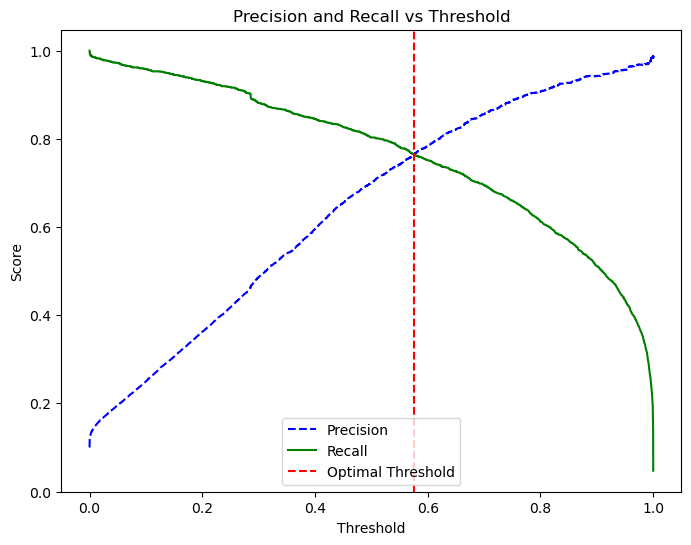

F1 Score with Threshold 0.575: 0.7650
Precision with Threshold 0.575: 0.7650
Recall with Threshold 0.575: 0.7650

Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21502
           1       0.76      0.76      0.76      2434

    accuracy                           0.95     23936
   macro avg       0.87      0.87      0.87     23936
weighted avg       0.95      0.95      0.95     23936


Confusion Matrix with Custom Threshold:
[[20930   572]
 [  572  1862]]
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step
Submission file saved to /Users/madsbian/Desktop/submission_Neural.csv


In [ ]:
# %pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Parameters
max_words = 80000  # Size of vocabulary
max_len = 200     # Max length of each comment
embedding_dim = 100  # Dimension of word embeddings

# Create tokenizer and process text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['comment_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Define Neural Network model
model = Sequential([
   Embedding(max_words, embedding_dim, input_length=max_len),
   GlobalAveragePooling1D(),
   Dense(16, activation='relu'),
   Dropout(0.5),
   Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
   optimizer='adam',
   loss='binary_crossentropy',
   metrics=['accuracy']
)

# Train model
history = model.fit(
   X_train_pad, y_train,
   epochs=5,
   batch_size=32,
   validation_data=(X_val_pad, y_val),
   verbose=1
)

# Get probabilities for validation set
y_val_probs = model.predict(X_val_pad)

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')

# Find optimal threshold
optimal_idx = np.argmin(np.abs(precisions[:-1] - recalls[:-1]))
optimal_threshold = thresholds[optimal_idx]
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.legend(loc='best')
plt.show()

# Make predictions using optimal threshold
y_val_custom_pred = (y_val_probs >= optimal_threshold).astype(int)

# Calculate metrics with optimal threshold
f1_custom = f1_score(y_val, y_val_custom_pred)
precision_custom = precision_score(y_val, y_val_custom_pred)
recall_custom = recall_score(y_val, y_val_custom_pred)

# Print metrics
print(f"F1 Score with Threshold {optimal_threshold:.3f}: {f1_custom:.4f}")
print(f"Precision with Threshold {optimal_threshold:.3f}: {precision_custom:.4f}")
print(f"Recall with Threshold {optimal_threshold:.3f}: {recall_custom:.4f}")
print("\nClassification Report with Custom Threshold:")
print(classification_report(y_val, y_val_custom_pred))
print("\nConfusion Matrix with Custom Threshold:")
print(confusion_matrix(y_val, y_val_custom_pred))

# Generate predictions for test set using optimal threshold
y_test_probs = model.predict(X_test_pad)
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

# Create submission DataFrame
results_df = pd.DataFrame({
   'id': test_df['id'],
   'comment_text': test_df['comment_text'],
   'target': y_test_pred.flatten()
})

# Save results
submission_df = results_df[['id', 'comment_text', 'target']]
output_path = '/Users/madsbian/Desktop/submission_Neural.csv'
submission_df.to_csv(output_path, index=False)
print(f"Submission file saved to {output_path}")